In [1]:
from seaturtles import *

#### input the site locations

In [2]:
site_file = 'SF_Downtown_Sites.csv'
sites = pd.read_csv(site_file)
n_sites = len(sites)

#### specify rupture index for OpenSHA (see the rupture selection Notebook)

In [3]:
name = 'SF_NSanAndreasM725_UCERF2'

rupture_forecast = 'WGCEP (2007) UCERF2 - Single Branch'
source_idx  = 127
rupture_idx = 636

rupture_dict = {'rupture_forecast':rupture_forecast,
                'source_idx':source_idx,
                'rupture_idx':rupture_idx}

#### select the number of realizations, a Ground Motion Model and the desired intensity measures

In [4]:
n_realizations = 10000

gmm = 'Chiou & Youngs (2014)'

# a list of the desired periods or None
sa_periods = None

if (sa_periods == None) & (gmm=='Chiou & Youngs (2014)'):
    sa_periods = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3,
                 0.4, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 7.5, 10.0]

##### set up the file names

In [5]:
output_folder = 'output_test/'
if not os.path.exists(output_folder[:-1]):
    os.makedirs(output_folder[:-1])

In [6]:
eq_input_file = output_folder + name + '.json'
eqhazard_file = output_folder + name + '_EQHazard.h5'
output_file = output_folder + name + '_Realizations.h5'

##### create the EQHazard input file

In [7]:
create_eqhazard_input(eq_input_file, rupture_dict, sites, gmm, sa_periods)

##### run EQHazard, convert output to an .h5 file

In [8]:
extract_eqhazard_data(EQHazard_file, eq_input_file, eqhazard_file)

EQHazard ran successfully.


##### simulate the ground motion maps

In [9]:
ground_motion_simulation(eqhazard_file, n_realizations, output_file)

##### retrieve the ground motion maps and statistics

In [10]:
ruptures = pd.read_hdf(output_file, key='Ruptures')
sites = pd.read_hdf(output_file, key='Sites')

display(ruptures)
display(sites)

with h5py.File(output_file, 'r') as hf:
    # list of periods
    periods = hf['Periods'][:]

    # OpenSHA output
    medians = hf['Medians'][:]
    between_event_std = hf['BetweenEvStdDevs'][:]
    within_event_std = hf['WithinEvStdDevs'][:]
    total_std = hf['TotalStdDevs'][:]
    
    # Ground Motion Simulation Maps
    ground_motions = hf['GroundMotions'][:]
    etas = hf['Etas'][:]
    between_event_residuals = hf['BetweenEvResiduals'][:]
    epsilons = hf['Epsilons'][:]
    within_event_residuals = hf['WithinEvResiduals'][:]
    
    [n_rups, n_sites, n_periods, n_realizations] = ground_motions.shape 

,Magnitude,SourceIndex,RuptureIndex
0,7.25,127,636


,Latitude,Longitude,Vs30
0,37.801610,-122.404813,800.0
1,37.795552,-122.407047,550.0
2,37.791894,-122.412574,800.0
3,37.799824,-122.418681,800.0
4,37.785252,-122.409592,550.0
5,37.785167,-122.394134,800.0
6,37.769954,-122.390094,180.0
7,37.776432,-122.403324,180.0
8,37.790440,-122.392161,180.0
9,37.807878,-122.410315,180.0


Site: 0, Vs30: 800


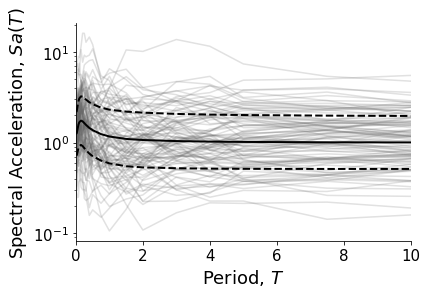

Site: 1, Vs30: 550


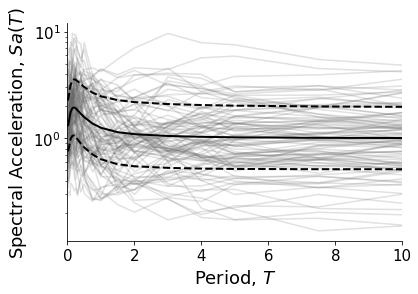

Site: 2, Vs30: 800


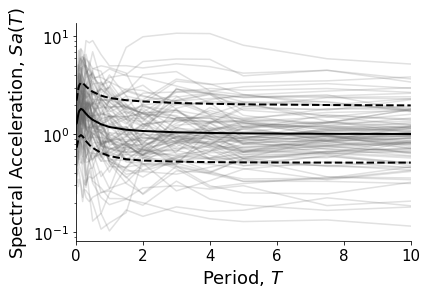

Site: 3, Vs30: 800


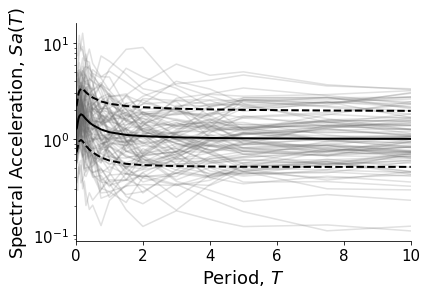

Site: 4, Vs30: 550


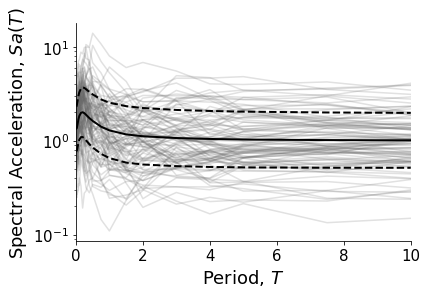

Site: 5, Vs30: 800


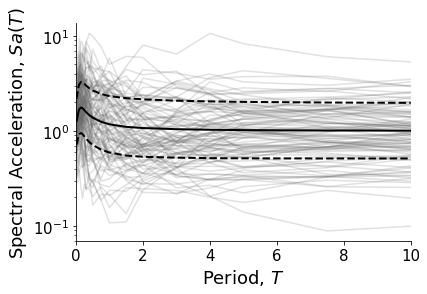

Site: 6, Vs30: 180


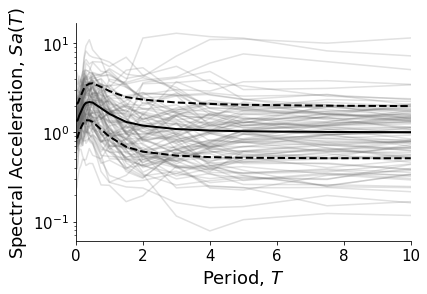

Site: 7, Vs30: 180


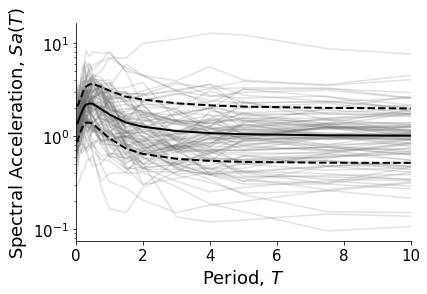

Site: 8, Vs30: 180


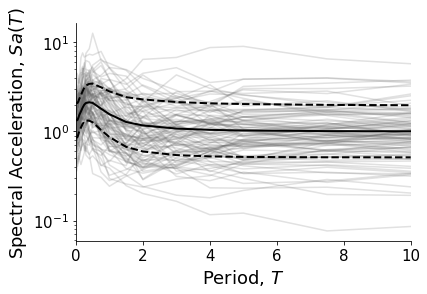

Site: 9, Vs30: 180


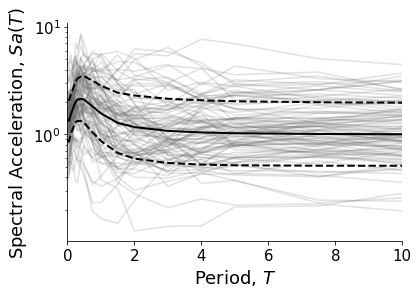

Site: 10, Vs30: 275


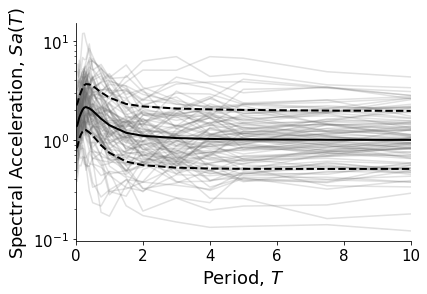

Site: 11, Vs30: 275


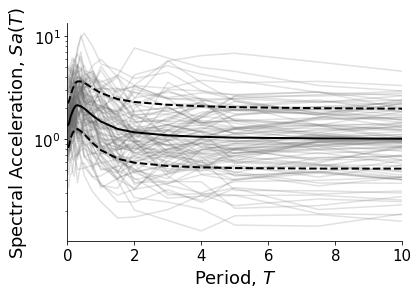

Site: 12, Vs30: 275


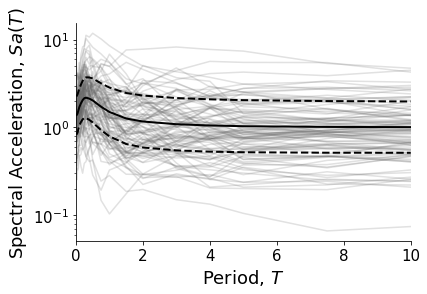

Site: 13, Vs30: 275


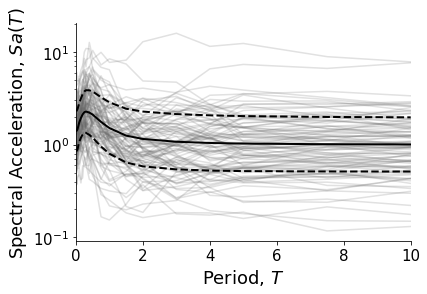

Site: 14, Vs30: 275


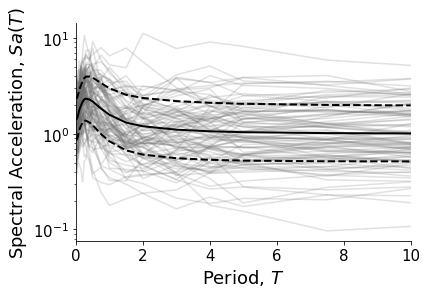

Site: 15, Vs30: 275


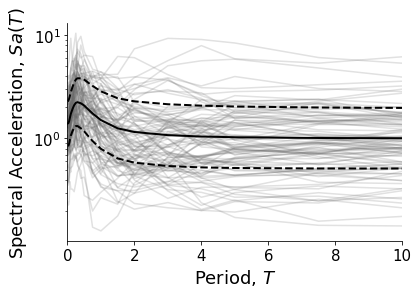

In [11]:
set_plot_formatting()

# plot the first n simulations
n_sims = 100

for i_rup in range(n_rups):
    for i_site in range(n_sites):
        print('Site: '+str(i_site)+', Vs30: '+'{0:.0f}'.format(sites.loc[i_site,'Vs30']))
        fig,ax = plt.subplots(1,1)
        _ = plt.plot(periods, np.exp(medians[i_rup,i_site,:]), color='k', linewidth=2)
        for a in [1,-1]:
            _ = plt.plot(periods, np.exp(medians[i_rup,i_site,:]+a*total_std[i_rup,i_site,:]), color='k', linestyle='--', linewidth=2)
        for i_real in range(n_sims):
            _ = plt.plot(periods, ground_motions[i_rup,i_site,:, i_real], color='dimgray', alpha=0.2, zorder=-1)
        _ = plt.xlabel('Period, $T$')
        _ = plt.xlim([0, max(periods)])
        _ = plt.ylabel('Spectral Acceleration, $Sa(T)$')
        
        if False:
            _ = plt.ylim(bottom=0)
        else:
            _ = plt.yscale('log')
            
        _ = ax.spines['top'].set_visible(False)
        _ = ax.spines['right'].set_visible(False)
        _ = plt.show()